In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.optim.lr_scheduler import StepLR

from model import EfficientNet_B0

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from voc_dataloader import VocDataset, VOC_CLASSES

%load_ext autoreload
%autoreload 2


In [2]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [3]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True, print_total=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)

        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        if print_total:
            print('mAP: {0:.4f}'.format(mAP))
            print('Avg loss: {}'.format(test_loss))

    return mAP, test_loss, aps

In [4]:
def plot_losses(train, val, test_frequency, num_epochs):
    plt.plot(train, label="train")
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_mAP(train, val, test_frequency, num_epochs):
    indices = [i for i in range(num_epochs) if ((i+1)%test_frequency == 0 or i ==0)]
    plt.plot(indices, train, label="train")
    plt.plot(indices, val, label="val")
    plt.title("mAP Plot")
    plt.ylabel("mAP")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()


## Training the network 

In [5]:
def train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency=5):
    train_losses = []
    train_mAPs = []
    val_losses = []
    val_mAPs = []

    for epoch in range(1,num_epochs+1):
        print("Starting epoch number " + str(epoch))
        train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
        train_losses.append(train_loss)
        print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
        if(epoch%test_frequency==0 or epoch==1):
            mAP_train, _, _ = test_classifier(train_loader, classifier, criterion, False, False)
            train_mAPs.append(mAP_train)
            mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
            print('Evaluating classifier')
            print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
            val_losses.append(val_loss)
            val_mAPs.append(mAP_val)
            
    return classifier, train_losses, val_losses, train_mAPs, val_mAPs

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

# Use random crop and flip for training
train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])

test_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

In [7]:
num_epochs = 100
test_frequency = 10
batch_size = 36
# set a higher number of workers for better performance
num_workers = 4

train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               pin_memory=True,
                                               num_workers=num_workers)

Efficient Net B0

started 1:39

In [8]:
classifier = EfficientNet_B0().to(device)

criterion = nn.MultiLabelSoftMarginLoss()

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
# scheduler = StepLR(optimizer, step_size=2, gamma=0.97)

classifier, train_losses, val_losses, train_mAPs, val_mAPs = \
    train(classifier, num_epochs, train_loader, val_loader, criterion, optimizer, test_frequency)



Starting epoch number 1
Loss for Training on Epoch 1 is 0.45290112495422363
-------  Class: aeroplane        AP:   0.0528  -------
-------  Class: bicycle          AP:   0.0523  -------
-------  Class: bird             AP:   0.0657  -------
-------  Class: boat             AP:   0.0400  -------
-------  Class: bottle           AP:   0.0446  -------
-------  Class: bus              AP:   0.0407  -------
-------  Class: car              AP:   0.1418  -------
-------  Class: cat              AP:   0.0729  -------
-------  Class: chair            AP:   0.1140  -------
-------  Class: cow              AP:   0.0302  -------
-------  Class: diningtable      AP:   0.0531  -------
-------  Class: dog              AP:   0.0882  -------
-------  Class: horse            AP:   0.0571  -------
-------  Class: motorbike        AP:   0.0526  -------
-------  Class: person           AP:   0.4049  -------
-------  Class: pottedplant      AP:   0.0470  -------
-------  Class: sheep            AP:   0.019

Loss for Training on Epoch 41 is 0.17563888430595398
Starting epoch number 42
Loss for Training on Epoch 42 is 0.17598822712898254
Starting epoch number 43
Loss for Training on Epoch 43 is 0.17250089347362518
Starting epoch number 44
Loss for Training on Epoch 44 is 0.17315499484539032
Starting epoch number 45
Loss for Training on Epoch 45 is 0.17308290302753448
Starting epoch number 46
Loss for Training on Epoch 46 is 0.16985280811786652
Starting epoch number 47
Loss for Training on Epoch 47 is 0.17014198005199432
Starting epoch number 48
Loss for Training on Epoch 48 is 0.17132879793643951
Starting epoch number 49
Loss for Training on Epoch 49 is 0.16829434037208557
Starting epoch number 50
Loss for Training on Epoch 50 is 0.1678904891014099
-------  Class: aeroplane        AP:   0.6323  -------
-------  Class: bicycle          AP:   0.1516  -------
-------  Class: bird             AP:   0.3053  -------
-------  Class: boat             AP:   0.4493  -------
-------  Class: bottle    

Loss for Training on Epoch 84 is 0.1371084451675415
Starting epoch number 85
Loss for Training on Epoch 85 is 0.13544237613677979
Starting epoch number 86
Loss for Training on Epoch 86 is 0.13514231145381927
Starting epoch number 87
Loss for Training on Epoch 87 is 0.13276782631874084
Starting epoch number 88
Loss for Training on Epoch 88 is 0.13290171325206757
Starting epoch number 89
Loss for Training on Epoch 89 is 0.13133610785007477
Starting epoch number 90
Loss for Training on Epoch 90 is 0.12936179339885712
-------  Class: aeroplane        AP:   0.6430  -------
-------  Class: bicycle          AP:   0.2904  -------
-------  Class: bird             AP:   0.3185  -------
-------  Class: boat             AP:   0.3380  -------
-------  Class: bottle           AP:   0.1823  -------
-------  Class: bus              AP:   0.2759  -------
-------  Class: car              AP:   0.5743  -------
-------  Class: cat              AP:   0.3421  -------
-------  Class: chair            AP:   0

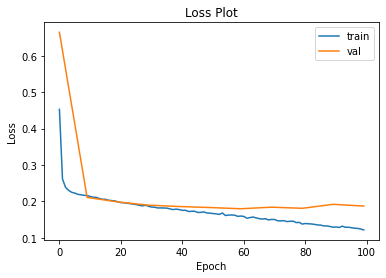

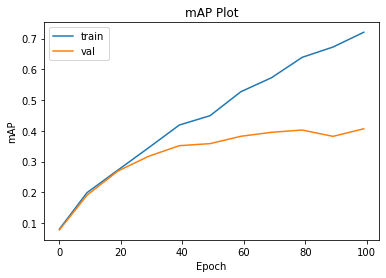

In [9]:
# Compare train and validation metrics
plot_losses(train_losses, val_losses, test_frequency, num_epochs)
plot_mAP(train_mAPs, val_mAPs, test_frequency, num_epochs)